In [1]:
import os
import random
import time
import copy
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
from time import sleep
from xml.dom import minidom

import torch
import cv2
import timm
from sklearn import preprocessing
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
from catalyst.data.sampler import BalanceClassSampler
from ranger import Ranger
#https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import albumentations as A
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, CoarseDropout,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, ShiftScaleRotate, CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2

import logging
logging.getLogger().setLevel(logging.INFO)

import warnings
warnings.filterwarnings('ignore')

In [2]:
# seed everything
SEED = 55555

random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [65]:
# hyperparameters
DATA_PATH = r"C:/Users/Dkrd/Documents/GitHub/plants_classification/train/"

IMAGE_SIZE = 250
BATCH_SIZE = 12
GRADIENT_ACCUMULATION_STEPS = 50
LEARNING_RATE = 0.0005
EPOCHS = 100
N_CLASS = 500

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    logging.info(f"Running on {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
    logging.info("Running on a CPU")

INFO:root:Running on GeForce GTX 1060 6GB


In [18]:
def build_dataset(quality_threshold=2, data_path=DATA_PATH):

    image_paths = []
    labels = []
    image_qualities = []

    for xmldoc in tqdm_notebook(os.listdir(data_path)):
        if xmldoc.__contains__(".xml"):
            with open(data_path + xmldoc, "r", encoding="UTF-8") as f:
                doc = f.read()
            doc = minidom.parseString(doc)

            label = doc.getElementsByTagName('ClassId')
            label = int(label[0].firstChild.nodeValue)

            image_path = doc.getElementsByTagName('FileName')
            image_path = image_path[0].firstChild.nodeValue            

            image_quality = doc.getElementsByTagName('Vote')
            image_quality = int(image_quality[0].firstChild.nodeValue)
            
            if image_quality > quality_threshold:
                image_paths.append(data_path + image_path)
                labels.append(label)
                image_qualities.append(image_quality)

            dataset = pd.DataFrame({'image_path' : image_paths,
                                    'label' : labels,
                                    'image_quality' : image_quality})

    return dataset

In [19]:
dataset = build_dataset()

In [38]:
len(dataset['label'].value_counts())

500

In [55]:
dataset['label'].value_counts().values[0]/len(dataset)

0.012760062220493876

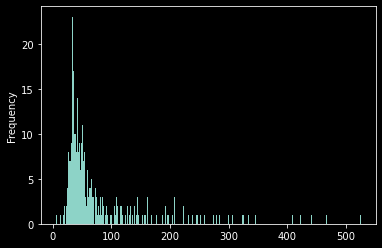

In [21]:
dataset['label'].value_counts().plot.hist(bins=500)

In [22]:
le = preprocessing.LabelEncoder()

In [23]:
dataset['label'] = le.fit_transform(dataset['label'].values)

In [56]:
train_dataset, test_dataset = train_test_split(dataset, shuffle=True, test_size=0.1, random_state=SEED)
train_dataset, valid_dataset = train_test_split(train_dataset, shuffle=True, test_size=0.2, random_state=SEED)
train_dataset_labels = train_dataset['label'].values

In [32]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transforms=None):
        super().__init__()
        self.image_paths = dataset['image_path'].values
        self.labels = dataset['label'].values
        self.image_qualities = dataset['image_quality'].values
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):        
        image, label = self.image_paths[index], self.labels[index]
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image)
        if image.shape[-1] == 4:
            # removing alpha channel if present
            image = image[..., :3]
        if len(image.shape) == 2:
            # converting single channel image to 3 channel for possible greyscales
            image = np.stack((image,)  * 3, axis = -1)

        if self.transforms is not None:
            transformed = self.transforms(image=image)

            image = transformed["image"]

        return image, label

transform = Compose([
            Resize(width=IMAGE_SIZE, height=IMAGE_SIZE),
            HorizontalFlip(p=0.4),
            ShiftScaleRotate(p=0.3),
            MedianBlur(blur_limit=7, always_apply=False, p=0.3),
            IAAAdditiveGaussianNoise(scale=(0, 0.15*255), p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.4),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            # in this implementation imagenet normalization is used            
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.4),
            ToTensorV2(p=1.0),
            ], p=1.0)

test_transform = Compose([
            # only resize and normalization is used for testing
            # no TTA is implemented in this solution
            Resize(width=IMAGE_SIZE, height=IMAGE_SIZE),                    
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
            ], p=1.0)


train_dataset, valid_dataset = Dataset(train_dataset, transforms = transform), Dataset(valid_dataset, transforms = transform)
test_dataset = Dataset(test_dataset, transforms = test_transform)

In [58]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transforms=None, image_size=250):
        super().__init__()
        self.images = self.get_images(dataset['image_path'].values)
        self.labels = dataset['label'].values
        self.image_qualities = dataset['image_quality'].values
        self.transforms = transforms
        self.image_size = image_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):        
        image, label = self.images[index], self.labels[index]        

        if self.transforms is not None:
            transformed = self.transforms(image=image)
            image = transformed["image"]

        return image, label

    def get_images(self, image_paths):
        images = []
        for image_path in tqdm_notebook(image_paths):
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (250, 250), interpolation=cv2.INTER_AREA)
            image = np.array(image)
            if image.shape[-1] == 4:
            # removing alpha channel if present
                image = image[..., :3]
            if len(image.shape) == 2:
            # converting single channel image to 3 channel for possible greyscales
                image = np.stack((image,)  * 3, axis = -1)
            images.append(image)

        return images

    transform = Compose([
                Resize(width=IMAGE_SIZE, height=IMAGE_SIZE),
                HorizontalFlip(p=0.4),
                ShiftScaleRotate(p=0.3),
                MedianBlur(blur_limit=7, always_apply=False, p=0.3),
                IAAAdditiveGaussianNoise(scale=(0, 0.15*255), p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.4),
                RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                # in this implementation imagenet normalization is used            
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
                CoarseDropout(p=0.5),
                Cutout(p=0.4),
                ToTensorV2(p=1.0),
                ], p=1.0)

    test_transform = Compose([
                # only resize and normalization is used for testing
                # no TTA is implemented in this solution
                Resize(width=IMAGE_SIZE, height=IMAGE_SIZE),                    
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
                ToTensorV2(p=1.0),
                ], p=1.0)


train_dataset, valid_dataset = Dataset(train_dataset, transforms=transform, image_size=250), Dataset(valid_dataset, transforms=transform, image_size=250)
test_dataset = Dataset(test_dataset, transforms=test_transform, image_size=250)

In [59]:
train_dataloader = DataLoader(
            train_dataset,
            #balanced sampler is used to minimize harmful effects of dataset not being fully balanced
            sampler=BalanceClassSampler(labels=train_dataset_labels, mode="upsampling"),
            #sampler = RandomSampler(train_dataset),
            batch_size = BATCH_SIZE)
valid_dataloader = DataLoader(
            valid_dataset,
            sampler = SequentialSampler(valid_dataset),
            batch_size = BATCH_SIZE)
test_dataloader = DataLoader(
            test_dataset,
            sampler = SequentialSampler(test_dataset),
            batch_size = 1)

In [60]:
class Classifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        
    def forward(self, x):
        x = self.model(x)

        return x

net = Classifier("tf_efficientnet_b3_ns", N_CLASS).to(device)

In [66]:
loss_function  = nn.CrossEntropyLoss()
#optimizer = Ranger(net.parameters(), lr=LEARNING_RATE, weight_decay = 0.999, betas = (0.9, 0.999))
optimizer = torch.optim.AdamW(net.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), weight_decay=0.999)
scheduler = CosineAnnealingLR(optimizer, EPOCHS * 0.25, LEARNING_RATE * 0.0001)
scheduler.last_epoch = EPOCHS
scaler = GradScaler()

def training_loop():
    best_model_wts = copy.deepcopy(net.state_dict())
    best_loss = float("inf")
    
    for epoch in (range(EPOCHS)):        
        if epoch != 0 and epoch > 0.25 * EPOCHS: # cosine anneal the last 25% of epochs
            scheduler.step()
        logging.info(f"Epoch {epoch+1}")

        logging.info("Training")
        train_losses, train_accuracies = forward_pass(train_dataloader, train = True)  

        logging.info("Validating")
        val_losses, val_accuracies = forward_pass(valid_dataloader)

        logging.info(f"Training accuracy:   {sum(train_accuracies)/len(train_accuracies):.2f} | Training loss: {sum(train_losses)/len(train_losses):.2f}")
        logging.info(f"Validation accuracy: {sum(val_accuracies)/len(val_accuracies):.2f} | Validation loss: {sum(val_losses)/len(val_losses):.2f}")
        
        epoch_val_loss = sum(val_losses)/len(val_losses)
        
        if best_loss > epoch_val_loss:    
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(net.state_dict())
            torch.save(net.state_dict(), "best.pth")
            logging.info(f"Saving with loss of {epoch_val_loss}, improved over previous {best_loss}")

In [67]:
def forward_pass(dataloader, draw=False, train=False):
    if train:
        net.train()
    else:
        net.eval()

    losses = []
    accuracies = []

    for step, batch in (enumerate(dataloader)):
        inputs = batch[0].to(device).float()
        labels = batch[1].to(device).long()          

        with autocast():
            if train:
                outputs = net(inputs)
                loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
            else:
                with torch.no_grad():
                    outputs = net(inputs)
                    loss = loss_function(outputs, labels)
        
        matches = [torch.argmax(i) == j for i, j in zip(outputs, labels)] 
        acc = matches.count(True)/len(matches)

        losses.append(loss)
        accuracies.append(acc)
        
        if train and (step+1) % GRADIENT_ACCUMULATION_STEPS == 0:
        # gradient accumulation to train with bigger effective batch size 
        # with less memory use
        # fp16 is used to speed up training and reduce memory consumption
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()            
            logging.info(f"Step {step} of {len(train_dataloader)},\t"\
                            f"Accuracy: {sum(accuracies)/len(accuracies):.2f},\t"\
                            f"Loss: {sum(losses)/len(losses):.2f}")

    return losses, accuracies


In [63]:
training_loop()

INFO:root:Epoch 1
INFO:root:Training
INFO:root:Step 49 of 15709,	Accuracy: 0.01,	Loss: 6.22
INFO:root:Step 99 of 15709,	Accuracy: 0.00,	Loss: 6.22
INFO:root:Step 149 of 15709,	Accuracy: 0.00,	Loss: 6.21
INFO:root:Step 199 of 15709,	Accuracy: 0.00,	Loss: 6.21
INFO:root:Step 249 of 15709,	Accuracy: 0.00,	Loss: 6.21
INFO:root:Step 299 of 15709,	Accuracy: 0.00,	Loss: 6.21
INFO:root:Step 349 of 15709,	Accuracy: 0.00,	Loss: 6.21
INFO:root:Step 399 of 15709,	Accuracy: 0.00,	Loss: 6.21
INFO:root:Step 449 of 15709,	Accuracy: 0.00,	Loss: 6.21
INFO:root:Step 499 of 15709,	Accuracy: 0.00,	Loss: 6.21
INFO:root:Step 549 of 15709,	Accuracy: 0.00,	Loss: 6.21


KeyboardInterrupt: 